In [1]:
#Importing
#!conda install geopandas --y
#!conda install imbalanced-learn --y
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools import add_constant
from statsmodels.robust.robust_linear_model import RLM

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
mean_absolute_error, mean_squared_error)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [132]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")
print(data.shape)

location_data = data.copy()

data.drop(columns=['event_type', 'source', 'notes', 'time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime
data = data.sort_values('event_date', ascending=True)
#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
print(data.shape)
#data = data.dropna(subset=['event_date'])
#print(data.shape)

(38130, 32)
(38130, 14)
(38130, 14)


In [3]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 9878 duplicates
(28252, 14)


In [4]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type',  'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2'] #'source', 'notes', 'event_type'
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill

#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(28252, 14)


In [5]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [6]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        24.720374
fatalities    88.906980
dtype: float64


In [7]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('sub_event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'sub_event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_sub_events'] = data.groupby(['sub_event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['sub_event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [8]:
#All data cleaning steps on LOCATION DATA
location_data['event_date'] = pd.to_datetime(location_data['event_date'], errors='coerce')  # Convert to datetime

location_data.sort_index(inplace=True)

# Drop duplicates and record the count before and after
initial_row_count = location_data.shape[0]
location_data.drop_duplicates(inplace=True)
final_row_count = location_data.shape[0]

# Fill missing categorical data
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
for column in categorical_columns:
    location_data[column] = location_data[column].fillna('Not specified')
    
# Fill missing numerical data
numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'longitude', 'latitude']
for column in numerical_columns:
    location_data[column] = location_data[column].fillna(location_data[column].median())

# Assume consolidate_names is a function that's already defined
location_data['actor1_grouped'] = location_data['actor1'].apply(consolidate_names)
location_data['actor2_grouped'] = location_data['actor2'].apply(consolidate_names)

# Calculate value counts for grouped actors
actor1_counts = location_data['actor1_grouped'].value_counts()
actor2_counts = location_data['actor2_grouped'].value_counts()

# Assume consolidate_small_groups is a function that's already defined
# Apply consolidation function based on counts
location_data['actor1_grouped'] = location_data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
location_data['actor2_grouped'] = location_data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))

# Update the 'actor1' and 'actor2' columns
location_data['actor1'] = location_data['actor1_grouped']
location_data['actor2'] = location_data['actor2_grouped']

# Drop the temporary grouped columns
location_data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

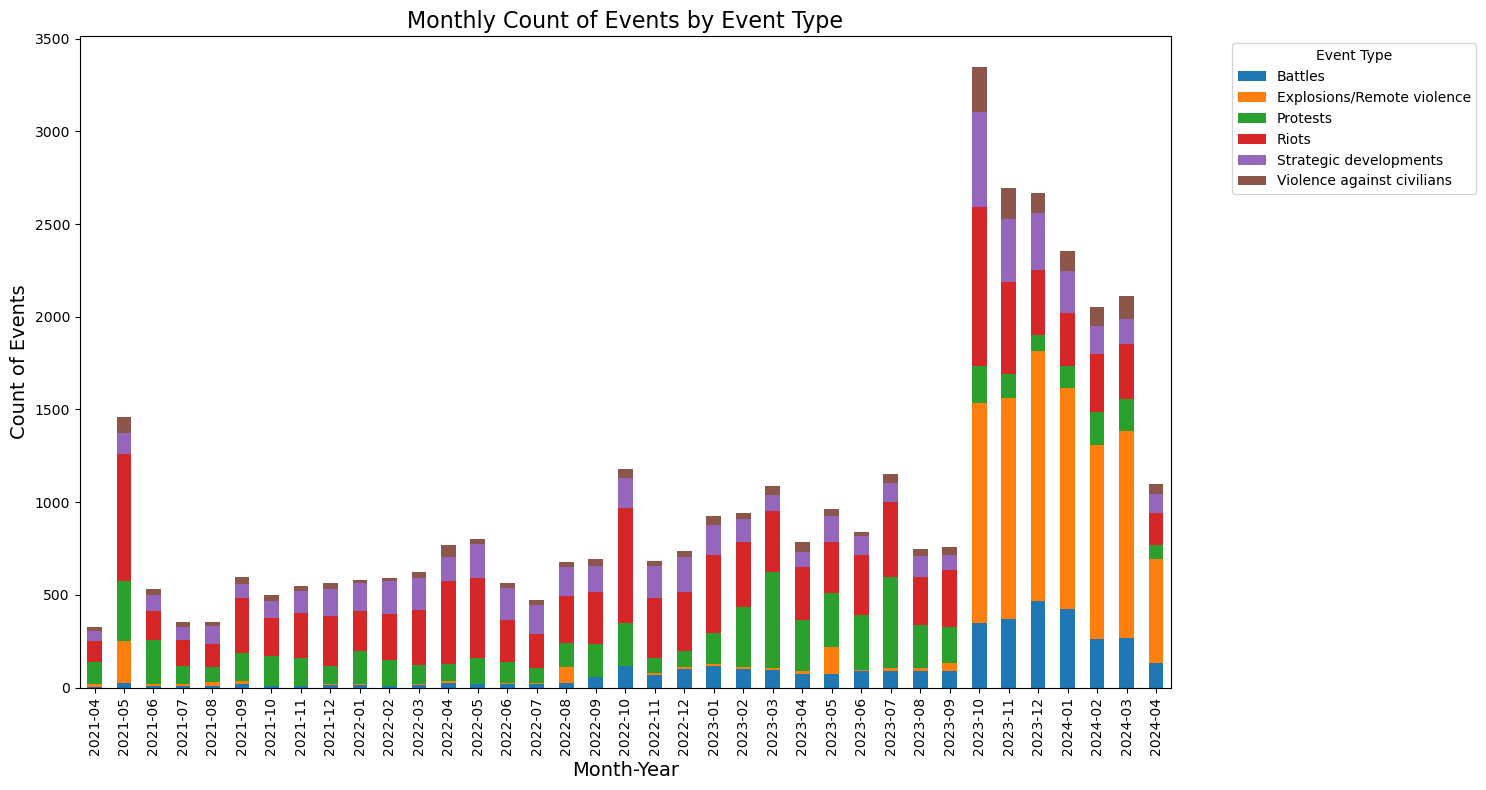

In [9]:
# Plotting the count of events over time by event_type
location_data['month_year'] = location_data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = location_data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

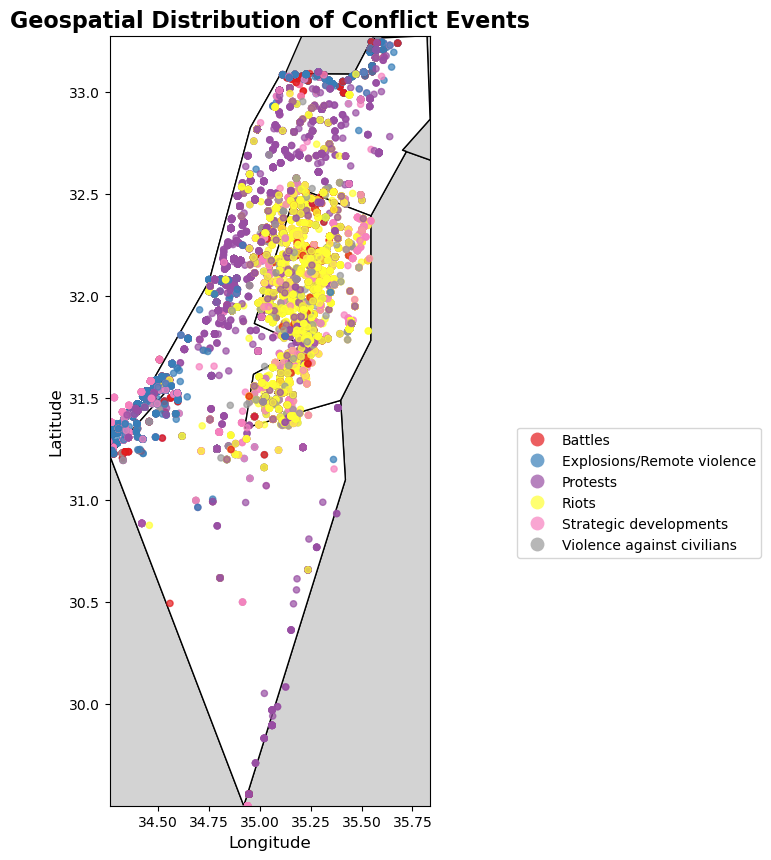

In [10]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=20, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [11]:
#log transformations
log_columns = ['fatalities', 'cumulative_sub_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

In [12]:
log_data

,event_date,year,disorder_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,civilian_targeting,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
38129,2021-04-20,2021,Strategic developments,Looting/property destruction,Hamas Movement,3,Military Forces of Israel,8,38,Not specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38117,2021-04-20,2021,Political violence,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,Civilian targeting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
38118,2021-04-20,2021,Demonstrations,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
38119,2021-04-20,2021,Demonstrations,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
38120,2021-04-20,2021,Political violence,Attack,Police Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.000000,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.133531,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
27,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Not specified,0,80,Not specified,...,0.133531,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
26,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
25,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.826679,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422


In [13]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                             0
year                                   0
disorder_type                          0
sub_event_type                         0
actor1                                 0
inter1                                 0
actor2                                 0
inter2                                 0
interaction                            0
civilian_targeting                     0
country                                0
admin1                                 0
admin2                                 0
fatalities                             0
month                                  0
day                                    0
day_of_week                            0
days_since_start                       0
time_since_last_event                 20
time_since_last_disorder               4
rolling_avg_fatalities_7d              0
cumulative_sub_events                  0
cumulative_fatalities                  0
log_fatalities                         0
log_cumulative_s

In [14]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [15]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(28252, 51)
event_date                            0
year                                  0
disorder_type                         0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_sub_events                 0
cumulative_fatalities                 0
log_fatalities                        0
log_cumulative_sub_events   

In [16]:
threshold = 70

# columns where the percentage of zero is higher than threshold
columns_to_drop = zero_percentage[zero_percentage > threshold].index

# drop
log_data = log_data.drop(columns=columns_to_drop)

print("Columns dropped:", columns_to_drop)
print("Shape of the new DataFrame:", log_data.shape)

Columns dropped: Index(['fatalities', 'time_since_last_event', 'time_since_last_disorder',
       'log_fatalities', 'log_time_since_last_event',
       'log_time_since_last_disorder', 'log_fatalities_lag1',
       'log_fatalities_lag2', 'log_fatalities_lag3',
       'log_time_since_last_event_lag1', 'log_time_since_last_event_lag2',
       'log_time_since_last_event_lag3', 'log_time_since_last_disorder_lag1',
       'log_time_since_last_disorder_lag2',
       'log_time_since_last_disorder_lag3'],
      dtype='object')
Shape of the new DataFrame: (28252, 36)


In [17]:
print(log_data.dtypes)
unique_counts = log_data.nunique()
print(unique_counts)

event_date                            datetime64[ns]
year                                           int32
disorder_type                                 object
sub_event_type                                object
actor1                                        object
inter1                                         int64
actor2                                        object
inter2                                         int64
interaction                                    int64
civilian_targeting                            object
country                                       object
admin1                                        object
admin2                                        object
month                                          int32
day                                            int32
day_of_week                                   object
days_since_start                               int64
rolling_avg_fatalities_7d                    float64
cumulative_sub_events                         

In [18]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'sub_event_type', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week', 'inter1', 'inter2', 'interaction']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['actor1', 'actor2']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [19]:
log_data_encoded

,event_date,year,actor1,actor2,month,day,days_since_start,rolling_avg_fatalities_7d,cumulative_sub_events,cumulative_fatalities,...,interaction_57,interaction_58,interaction_60,interaction_66,interaction_68,interaction_70,interaction_77,interaction_78,interaction_80,interaction_88
38129,2021-04-20,2021,3,7,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
38117,2021-04-20,2021,19,2,4,20,0,0.000000,1,0,...,1,0,0,0,0,0,0,0,0,0
38118,2021-04-20,2021,17,9,4,20,0,0.000000,1,0,...,0,0,1,0,0,0,0,0,0,0
38119,2021-04-20,2021,17,9,4,20,0,0.000000,2,0,...,0,0,1,0,0,0,0,0,0,0
38120,2021-04-20,2021,14,2,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2024-04-19,2024,8,2,4,19,1095,1.285714,3002,26163,...,0,0,0,0,0,0,0,1,0,0
27,2024-04-19,2024,8,9,4,19,1095,1.285714,3003,26163,...,0,0,0,0,0,0,0,0,1,0
26,2024-04-19,2024,8,2,4,19,1095,1.285714,3004,26163,...,0,0,0,0,0,0,0,1,0,0
25,2024-04-19,2024,8,2,4,19,1095,1.428571,3005,26164,...,0,0,0,0,0,0,0,1,0,0


In [20]:
print(log_data_encoded.dtypes)
unique_counts = log_data_encoded.nunique()
#print(unique_counts)

event_date        datetime64[ns]
year                       int32
actor1                     int64
actor2                     int64
month                      int32
                       ...      
interaction_70             int64
interaction_77             int64
interaction_78             int64
interaction_80             int64
interaction_88             int64
Length: 146, dtype: object


In [102]:
log_data['sub_event_type'].unique()

array(['Looting/property destruction', 'Mob violence', 'Peaceful protest',
       'Attack', 'Violent demonstration', 'Other',
       'Change to group/activity', 'Shelling/artillery/missile attack',
       'Protest with intervention', 'Disrupted weapons use',
       'Air/drone strike', 'Excessive force against protesters',
       'Armed clash', 'Remote explosive/landmine/IED', 'Arrests',
       'Agreement', 'Grenade', 'Abduction/forced disappearance',
       'Non-state actor overtakes territory',
       'Government regains territory'], dtype=object)

In [21]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()
correlation_matrix

threshold = 0.75
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)
print(log_data_encoded.shape)

['log_cumulative_sub_events', 'log_rolling_avg_fatalities_7d', 'log_days_since_start', 'log_days_since_start_lag1', 'log_days_since_start_lag2', 'log_days_since_start_lag3', 'disorder_type_Political violence', 'sub_event_type_Air/drone strike', 'sub_event_type_Excessive force against protesters', 'sub_event_type_Peaceful protest', 'admin2_Beer Sheva', 'admin2_Jerusalem', 'admin2_Tel Aviv', 'inter1_5', 'inter1_6', 'interaction_12', 'interaction_27', 'interaction_38', 'interaction_47', 'interaction_55', 'interaction_60', 'interaction_66', 'interaction_70', 'interaction_78']
(28252, 146)


In [82]:
log_data_encoded

,event_date,year,actor1,actor2,month,day,days_since_start,rolling_avg_fatalities_7d,cumulative_sub_events,cumulative_fatalities,...,interaction_57,interaction_58,interaction_60,interaction_66,interaction_68,interaction_70,interaction_77,interaction_78,interaction_80,interaction_88
38129,2021-04-20,2021,3,7,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
38117,2021-04-20,2021,19,2,4,20,0,0.000000,1,0,...,1,0,0,0,0,0,0,0,0,0
38118,2021-04-20,2021,17,9,4,20,0,0.000000,1,0,...,0,0,1,0,0,0,0,0,0,0
38119,2021-04-20,2021,17,9,4,20,0,0.000000,2,0,...,0,0,1,0,0,0,0,0,0,0
38120,2021-04-20,2021,14,2,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2024-04-19,2024,8,2,4,19,1095,1.285714,3002,26163,...,0,0,0,0,0,0,0,1,0,0
27,2024-04-19,2024,8,9,4,19,1095,1.285714,3003,26163,...,0,0,0,0,0,0,0,0,1,0
26,2024-04-19,2024,8,2,4,19,1095,1.285714,3004,26163,...,0,0,0,0,0,0,0,1,0,0
25,2024-04-19,2024,8,2,4,19,1095,1.428571,3005,26164,...,0,0,0,0,0,0,0,1,0,0


In [22]:
# target columns
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]

# taking out the features, datetime
features = log_data_encoded.drop(columns=['event_date'] + sub_event_type_columns)

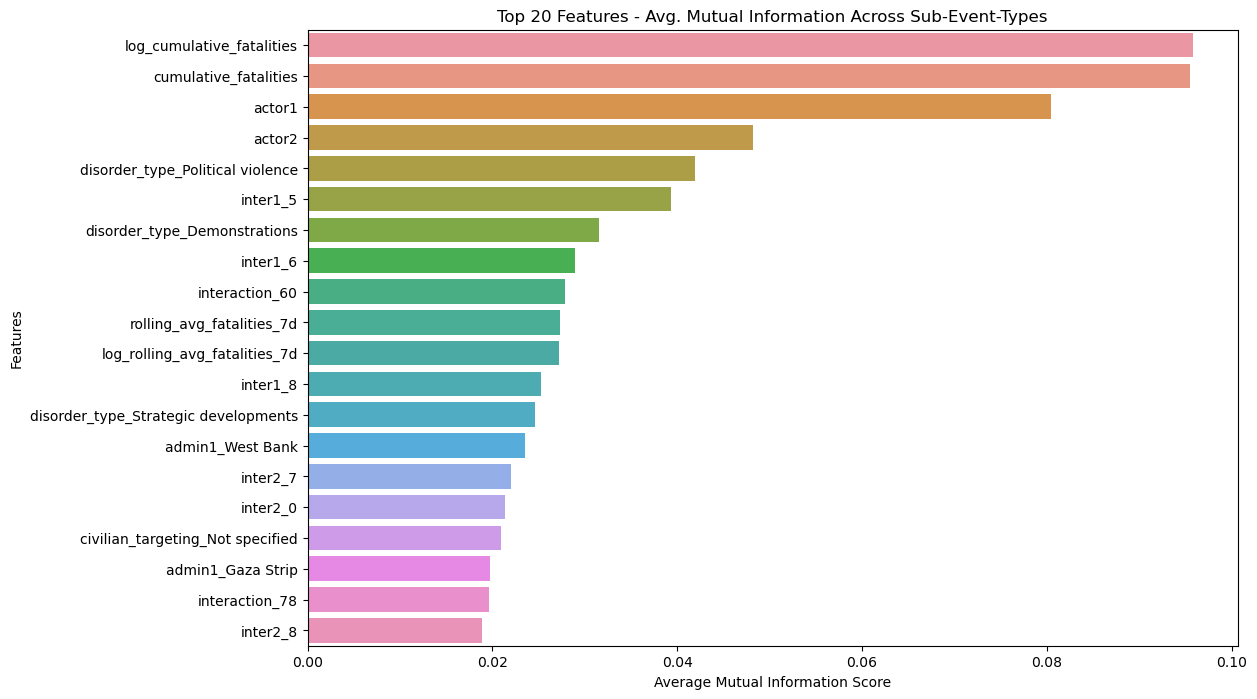

In [23]:
#Mututal Information features

# actual mi score calculation
mi_scores_df = pd.DataFrame()

for target in sub_event_type_columns:
    mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')
    mi_scores_df[target] = mi_scores

#creating mi_scores + top 20 features shown below
mi_scores_df['average_mi_score'] = mi_scores_df.mean(axis=1)
mi_scores_df['feature'] = features.columns

#if 'feature' in mi_scores_df.columns:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20)['feature'].tolist()
#else:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20).index.tolist()

plt.figure(figsize=(12, 8))
sns.barplot(x='average_mi_score', y='feature', data=mi_scores_df.sort_values('average_mi_score', ascending=False).head(20))
plt.title('Top 20 Features - Avg. Mutual Information Across Sub-Event-Types')
plt.xlabel('Average Mutual Information Score')
plt.ylabel('Features')
plt.show()

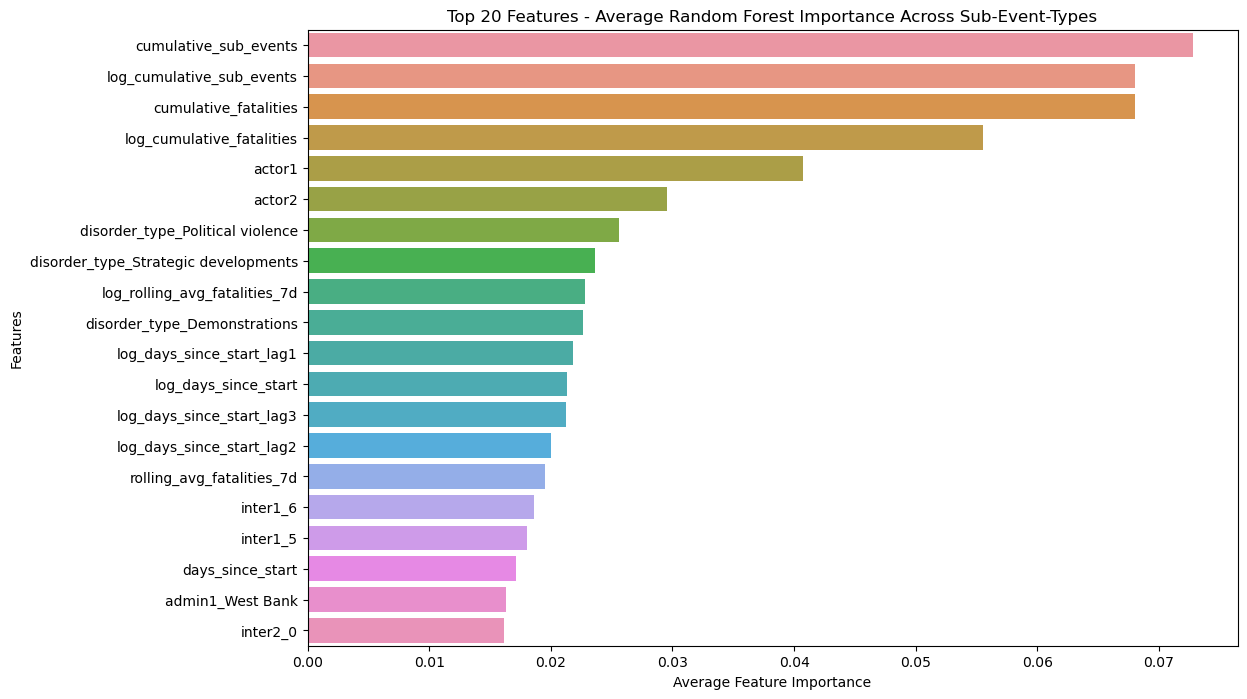

In [24]:
#Random Forest Importance

#feature importances
importances_df = pd.DataFrame(index=features.columns)

for target in sub_event_type_columns:
    X_train, X_test, y_train, y_test = train_test_split(features, log_data_encoded[target], test_size=0.2, random_state=42, shuffle=False)
    forest = RandomForestClassifier(random_state=42)
    forest.fit(X_train, y_train)
    importances_df[target] = forest.feature_importances_

# average feature importance across all sub_event_types
importances_df['average_importance'] = importances_df.mean(axis=1)

#if 'feature' in importances_df.columns:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20)['feature'].tolist()
#else:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20).index.tolist()


# average feature importances
plt.figure(figsize=(12, 8))
sorted_importances = importances_df['average_importance'].sort_values(ascending=False).head(20)
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Top 20 Features - Average Random Forest Importance Across Sub-Event-Types')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.show()

In [25]:
print(mi_scores_df.shape)
print(importances_df.shape)

(125, 22)
(125, 21)


In [26]:
# MI score
mi_percentile = 80  # aka keeping top 20%
mi_threshold = np.percentile(mi_scores_df['average_mi_score'], mi_percentile)
selected_mi_features = mi_scores_df[mi_scores_df['average_mi_score'] >= mi_threshold]['feature'].tolist()

# random forest importance
rf_percentile = 80  # aka keeping top 20% | top 30% is 43 features
rf_threshold = np.percentile(importances_df['average_importance'], rf_percentile)
selected_rf_features = importances_df[importances_df['average_importance'] >= rf_threshold].index.tolist()

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))
print(selected_features)

['log_cumulative_fatalities', 'inter2_0', 'log_days_since_start_lag2', 'disorder_type_Demonstrations', 'log_days_since_start_lag3', 'inter1_6', 'actor2', 'inter1_5', 'admin1_West Bank', 'admin1_Gaza Strip', 'disorder_type_Strategic developments', 'civilian_targeting_Not specified', 'disorder_type_Political violence', 'log_rolling_avg_fatalities_7d', 'actor1', 'cumulative_fatalities', 'days_since_start', 'rolling_avg_fatalities_7d', 'log_days_since_start']


In [27]:
print(len(selected_features))
print(len(set(selected_features))) #unique


19
19


In [28]:
#Checking Data Stats

Class Distribution:
sub_event_type_Abduction/forced disappearance          0.021237
sub_event_type_Agreement                               0.021237
sub_event_type_Air/drone strike                       10.636415
sub_event_type_Armed clash                            10.179810
sub_event_type_Arrests                                 0.286705
sub_event_type_Attack                                  6.353532
sub_event_type_Change to group/activity                0.700835
sub_event_type_Disrupted weapons use                   2.074189
sub_event_type_Excessive force against protesters      0.261928
sub_event_type_Government regains territory            0.007079
sub_event_type_Grenade                                 0.651281
sub_event_type_Looting/property destruction            6.870310
sub_event_type_Mob violence                           25.230072
sub_event_type_Non-state actor overtakes territory     0.010619
sub_event_type_Other                                   6.144698
sub_event_type_Peace

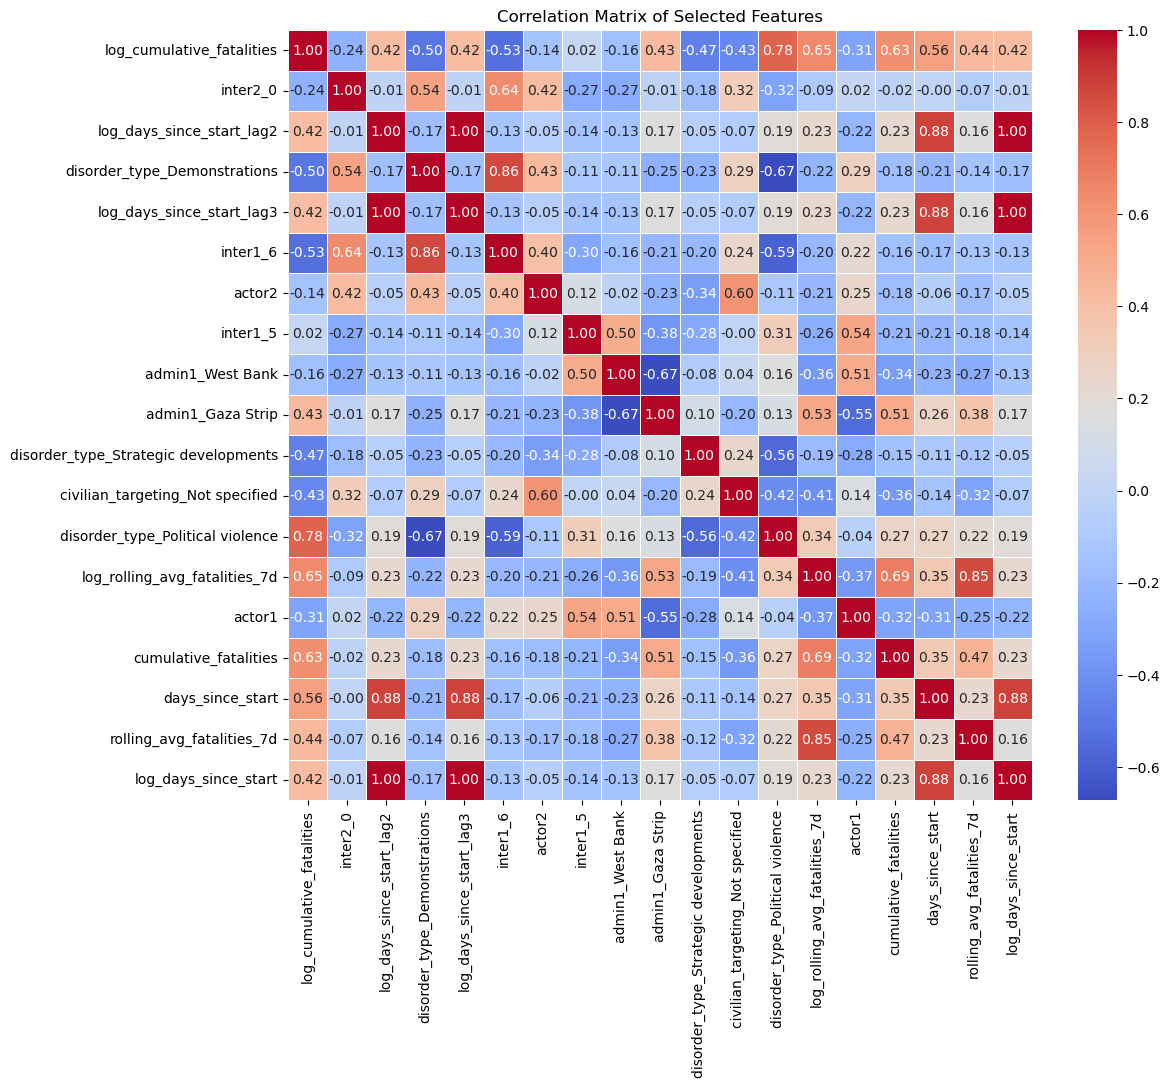

In [29]:
# Class Imbalance
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]
class_counts = log_data_encoded[sub_event_type_columns].sum()
class_percentages = class_counts / len(log_data_encoded) * 100
print("Class Distribution:")
print(class_percentages)

# Multicollinearity
selected_data = log_data_encoded[selected_features]
correlation_matrix = selected_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The following code shows us that there are a few features with high class imbalances: 5 values above 9%
We also have a few features that have a high correlation such as 'log_days_since_start_lag' 1 2 and 3 all have a correlation of 1.0 indicating the presence of multicollinearity. 

In [30]:
def test_stationarity(timeseries):
    # ADF test
    adf_result = adfuller(timeseries)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    # KPSS test
    kpss_result = kpss(timeseries)
    print(f"KPSS Statistic: {kpss_result[0]}")
    print(f"p-value: {kpss_result[1]}")

for col in selected_features:
    print(f"Stationarity Test for {col}:")
    test_stationarity(log_data_encoded[col])
    print()

Stationarity Test for log_cumulative_fatalities:
ADF Statistic: -5.074658030079506
p-value: 1.576063548372852e-05
KPSS Statistic: 27.497229505058357
p-value: 0.01

Stationarity Test for inter2_0:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -36.609340507498274
p-value: 0.0
KPSS Statistic: 0.8160568961717696
p-value: 0.01

Stationarity Test for log_days_since_start_lag2:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.529521402118622
p-value: 0.0
KPSS Statistic: 18.25131679501164
p-value: 0.01

Stationarity Test for disorder_type_Demonstrations:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.500576985460892
p-value: 2.9825356893457593e-25
KPSS Statistic: 17.741149528402982
p-value: 0.01

Stationarity Test for log_days_since_start_lag3:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.736751798754387
p-value: 0.0
KPSS Statistic: 18.25049794739106
p-value: 0.01

Stationarity Test for inter1_6:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.70643818910814
p-value: 1.2612161463875373e-25
KPSS Statistic: 15.619748984908377
p-value: 0.01

Stationarity Test for actor2:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -16.731393601337686
p-value: 1.3821609593477742e-29
KPSS Statistic: 6.1599406817822375
p-value: 0.01

Stationarity Test for inter1_5:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.56141579998013
p-value: 2.0985350234908663e-23
KPSS Statistic: 26.4033832640823
p-value: 0.01

Stationarity Test for admin1_West Bank:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.784549070852114
p-value: 7.294002601329369e-24
KPSS Statistic: 22.671058679138742
p-value: 0.01

Stationarity Test for admin1_Gaza Strip:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -9.703117671080607
p-value: 1.059160715999903e-16
KPSS Statistic: 23.026164021344872
p-value: 0.01

Stationarity Test for disorder_type_Strategic developments:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -16.040629327255946
p-value: 5.919405431313334e-29
KPSS Statistic: 15.251725858298274
p-value: 0.01

Stationarity Test for civilian_targeting_Not specified:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.70117327677458
p-value: 1.288847729226622e-25
KPSS Statistic: 21.267571538663727
p-value: 0.01

Stationarity Test for disorder_type_Political violence:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -10.458451645543066
p-value: 1.3789295167541213e-18
KPSS Statistic: 25.317794785408232
p-value: 0.01

Stationarity Test for log_rolling_avg_fatalities_7d:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -8.585712841975262
p-value: 7.517374719304192e-14
KPSS Statistic: 21.315326181886878
p-value: 0.01

Stationarity Test for actor1:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -8.86162822032417
p-value: 1.4775316401192507e-14
KPSS Statistic: 23.90517730009339
p-value: 0.01

Stationarity Test for cumulative_fatalities:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -6.529160950413836
p-value: 9.969972209061724e-09
KPSS Statistic: 24.96437504288526
p-value: 0.01

Stationarity Test for days_since_start:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.781355335995366
p-value: 7.403729714320849e-24
KPSS Statistic: 27.3458485907781
p-value: 0.01

Stationarity Test for rolling_avg_fatalities_7d:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -14.53744548314206
p-value: 5.211250919162529e-27
KPSS Statistic: 13.402199120352824
p-value: 0.01

Stationarity Test for log_days_since_start:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.71156693287082
p-value: 0.0
KPSS Statistic: 18.25286684466152
p-value: 0.01



/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_58255/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


P-Values are almost all near 0 indicating that we can reject the null hypothesis of non-stationarity. Suggests that the selected features are likely stationary which is what we want!

In [31]:
def test_heteroscedasticity(y, X):
    X_const = add_constant(X)
    
    # Breusch-Pagan test
    bp_result = het_breuschpagan(y, X_const)
    print(f"Breusch-Pagan Statistic: {bp_result[0]}")
    print(f"p-value: {bp_result[1]}")

In [32]:
X = log_data_encoded[selected_features]

for col in sub_event_type_columns:
    print(f"Heteroscedasticity Test for {col}:")
    y = log_data_encoded[col]
    test_heteroscedasticity(y, X)
    print()

Heteroscedasticity Test for sub_event_type_Abduction/forced disappearance:
Breusch-Pagan Statistic: 319.0047259125629
p-value: 2.5091994032308255e-56

Heteroscedasticity Test for sub_event_type_Agreement:
Breusch-Pagan Statistic: 114.02844349645254
p-value: 1.4351625667163519e-15

Heteroscedasticity Test for sub_event_type_Air/drone strike:
Breusch-Pagan Statistic: 23312.461491647988
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Armed clash:
Breusch-Pagan Statistic: 15261.876246099526
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Arrests:
Breusch-Pagan Statistic: 608.51536618779
p-value: 8.049538287179186e-117

Heteroscedasticity Test for sub_event_type_Attack:
Breusch-Pagan Statistic: 13423.014048752342
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Change to group/activity:
Breusch-Pagan Statistic: 4083.0706636777686
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Disrupted weapons use:
Breusch-Pagan Statistic: 8302.994395703428
p-value: 0.0



Indication of heteroskedasticity due to p-values < 0.05 + extremely large BP stat! - Non Constant Variance throughout observations

In [33]:
#X = sm.add_constant(log_data_encoded[selected_features])

#for col in sub_event_type_columns:
   # print(f"OLS Regression with Robust Standard Errors for {col}")
   # y = log_data_encoded[col]
   # model = sm.OLS(y, X)
   # results = model.fit(cov_type='HC1')  # 'HC1' for robust standard errors
   # print(results.summary())
   # print("\n")

In [34]:
#for col in sub_event_type_columns:
  #  print(f"RLM Regression for {col}")
  #  y = log_data_encoded[col]
    
    # Initialize RLM with HuberT norm for robustness
  #  model_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT())
  #  results_rlm = model_rlm.fit()
    
  #  print(results_rlm.summary())
  #  print("\n")

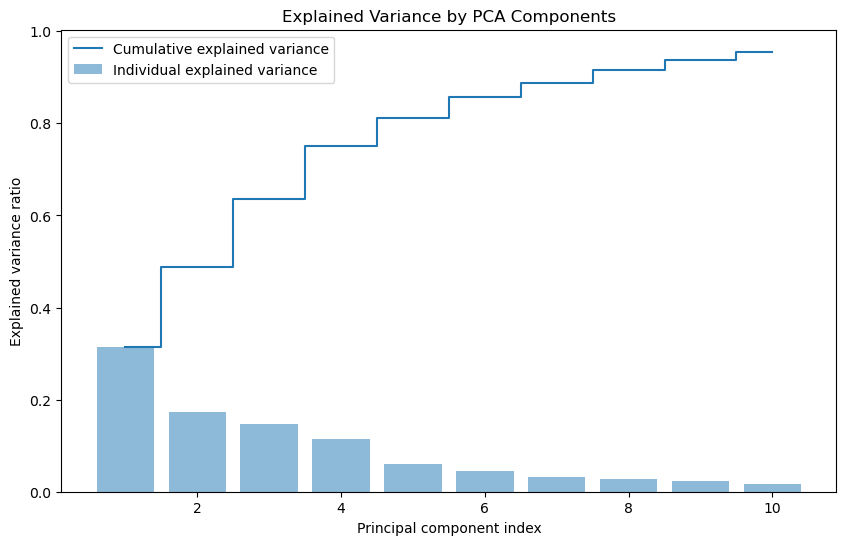

In [35]:
# standardizing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(log_data_encoded[selected_features])

# attempt to fix Multicollinearity with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(features_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

In [36]:
print("Number of PCA components selected:", pca.n_components_)

Number of PCA components selected: 10


In [79]:
#Save log_encoded_data and X_pca
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
PCA_df = pd.DataFrame(X_pca)
PCA_df.to_csv('data/X_PCA.csv', index=False)

In [37]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = log_data_encoded[sub_event_type_columns].values

X_train, X_test, y_train, y_test , train_idx, test_idx = train_test_split(X_pca, y, log_data_encoded.index ,
                                                                          test_size=0.2, random_state=42, shuffle=False)

y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

#y_train_encoded = tf.keras.utils.to_categorical(y_train)
#y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [38]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Labels for Y")
print(y_train_labels.shape)
print(y_test_labels.shape)
print(y_train_labels.dtype)
print(y_test_labels.dtype)
print(train_idx.shape)
print(test_idx.shape)
#print(X_train.dtypes)

(22601, 10)
(5651, 10)
(22601, 20)
(5651, 20)
Labels for Y
(22601,)
(5651,)
int64
int64
(22601,)
(5651,)


In [39]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [40]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 0.73
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.84      0.77      0.80      1421
           3       0.59      0.84      0.69       832
           4       0.00      0.00      0.00        17
           5       0.78      0.80      0.79       363
           6       0.46      1.00      0.63         6
           7       0.64      0.79      0.70       149
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.13      0.85      0.23        59
          11       0.85      0.97      0.91       280
          12       1.00      0.44      0.61       783
          13       0.00      0.00      0.00         0
          14       0.55      0.58      0.56        64
          15       0.98      1.00      0.99       388
          16       0.98      0.88      0.92      

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Logistic Regression
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train, y_train_labels)

logistic_predictions = logistic_regressor.predict(X_test)
logistic_accuracy = accuracy_score(y_test_labels, logistic_predictions)
logistic_classification_report = classification_report(y_test_labels, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.86
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.86      1.00      0.93      1421
           3       0.79      0.97      0.87       832
           4       0.00      0.00      0.00        17
           5       0.95      0.75      0.84       363
           6       0.29      1.00      0.44         6
           7       0.87      0.97      0.92       149
          10       0.95      0.92      0.93        59
          11       0.83      0.55      0.66       280
          12       1.00      1.00      1.00       783
          14       0.15      0.33      0.20        64
          15       1.00      0.98      0.99       388
          16       0.85      0.98      0.91        48
          17       0.00      0.00      0.00        60
          18       0.88      0.66      0.76      1123
          19       1.00      1.00      1.00        56

    accuracy                     

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [42]:
#Selected Features FOR LSTM input
def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps])
    return np.array(X)

n_steps = 24 # Number of timesteps
n_features = X_train.shape[1] # Number of features per step

#Reshaping data
X_train_reshaped = create_sequences(X_train, n_steps)
X_test_reshaped = create_sequences(X_test, n_steps)

#matching labels to new data
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

In [43]:
#Grid Search for Hyperparameters - LSTM
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly = True)
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [24, X_train_reshaped.shape[2], 50, 0.1, len(np.unique(y_train_reshaped))], #Testing 10% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 50, 0.2, len(np.unique(y_train_reshaped))], #Testing 20% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.2, len(np.unique(y_train_reshaped))], #testing 20% dropout and 100 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.3, len(np.unique(y_train_reshaped))], #testing 30% dropout and 100 neurons, 24 time steps
]

# run model with configs
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, 
                        callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

#running the grid search
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

2024-05-05 15:13:38.921750: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-05 15:13:38.921880: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-05 15:13:38.921903: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-05 15:13:38.922277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-05 15:13:38.922933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50
318/318 [==============================] - 15s 45ms/step - loss: 1.4455 - accuracy: 0.5737 - val_loss: 1.1071 - val_accuracy: 0.6213
Epoch 2/50
318/318 [==============================] - 13s 41ms/step - loss: 0.4017 - accuracy: 0.9027 - val_loss: 0.6459 - val_accuracy: 0.7857
Epoch 3/50
318/318 [==============================] - 14s 44ms/step - loss: 0.2444 - accuracy: 0.9330 - val_loss: 0.5353 - val_accuracy: 0.8392
Epoch 4/50
318/318 [==============================] - 14s 45ms/step - loss: 0.2002 - accuracy: 0.9419 - val_loss: 0.4709 - val_accuracy: 0.8534
Epoch 5/50
318/318 [==============================] - 20s 64ms/step - loss: 0.1751 - accuracy: 0.9485 - val_loss: 0.4176 - val_accuracy: 0.8667
Epoch 6/50
318/318 [==============================] - 14s 43ms/step - loss: 0.1573 - accuracy: 0.9538 - val_loss: 0.3853 - val_accuracy: 0.8773
Epoch 7/50
318/318 [==============================] - 17s 52ms/step - loss: 0.1481 - accuracy: 0.9550 - val_loss: 0.4032 - val_accuracy:

In [44]:
# Retraining Actual Model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
    return model

# best parameters
best_params = best_config

# model using the best parameters
LSTM_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = LSTM_model_best.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64,
                              validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/50
318/318 [==============================] - 16s 50ms/step - loss: 1.0879 - accuracy: 0.6813 - val_loss: 0.7560 - val_accuracy: 0.7343
Epoch 2/50
318/318 [==============================] - 13s 42ms/step - loss: 0.2645 - accuracy: 0.9251 - val_loss: 0.4766 - val_accuracy: 0.8543
Epoch 3/50
318/318 [==============================] - 13s 41ms/step - loss: 0.2034 - accuracy: 0.9392 - val_loss: 0.4779 - val_accuracy: 0.8251
Epoch 4/50
318/318 [==============================] - 12s 38ms/step - loss: 0.1778 - accuracy: 0.9454 - val_loss: 0.4239 - val_accuracy: 0.8640
Epoch 5/50
318/318 [==============================] - 13s 41ms/step - loss: 0.1587 - accuracy: 0.9506 - val_loss: 0.3632 - val_accuracy: 0.8733
Epoch 6/50
318/318 [==============================] - 13s 41ms/step - loss: 0.1486 - accuracy: 0.9529 - val_loss: 0.3799 - val_accuracy: 0.8756
Epoch 7/50
318/318 [==============================] - 12s 39ms/step - loss: 0.1390 - accuracy: 0.9561 - val_loss: 0.3436 - val_accuracy:

In [45]:
# Evaluation
_, accuracy = LSTM_model_best.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
print(f'Test Accuracy LSTM: {accuracy:.3f}')

# Predictions
y_pred_LSTM = LSTM_model_best.predict(X_test_reshaped)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1) # converting probabilities to class labels

# Actual classes
actual_classes_LSTM = y_test_reshaped  

# Metrics
mae_LSTM = mean_absolute_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Absolute Error LSTM: {mae_LSTM:.2f}')

mse_LSTM = mean_squared_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Squared Error LSTM: {mse_LSTM:.2f}')

rmse_LSTM = np.sqrt(mse_LSTM)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM:.2f}')

Test Accuracy LSTM: 0.881
176/176 [==============================] - 2s 11ms/step
Mean Absolute Error LSTM: 1.21
Mean Squared Error LSTM: 15.84
Root Mean Squared Error LSTM: 3.98


In [46]:
sub_event_type_labels = [col.split('_')[-1] for col in sub_event_type_columns]

predicted_labels_LSTM = [sub_event_type_labels[i] for i in y_pred_classes_LSTM]
actual_labels_LSTM = [sub_event_type_labels[i] for i in actual_classes_LSTM]

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Looting/property destruction
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Armed clash
Actual: Grenade, Predicted: Grenade
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [47]:
# Showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10
    print(f'Index: {i}, Predicted: {predicted_labels_LSTM[i]}, Actual: {actual_labels_LSTM[i]}')

Number of errors LSTM: 667 / 5628
Index: 2, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 17, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 18, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 19, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 20, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 39, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 40, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 45, Predicted: Air/drone strike, Actual: Shelling/artillery/missile attack
Index: 57, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 70, Predicted: Shelling/artillery/missile attack, Actual: Attack


              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000     2.000000
2              0.937169  1.000000  0.967566  1417.000000
3              0.797456  0.986683  0.882035   826.000000
4              0.000000  0.000000  0.000000    17.000000
5              0.967742  0.743802  0.841121   363.000000
6              0.500000  0.666667  0.571429     6.000000
7              0.478548  0.973154  0.641593   149.000000
10             0.712329  0.881356  0.787879    59.000000
11             0.835165  0.544803  0.659436   279.000000
12             1.000000  1.000000  1.000000   778.000000
14             0.375000  0.096774  0.153846    62.000000
15             0.997396  0.987113  0.992228   388.000000
16             0.903846  0.979167  0.940000    48.000000
17             0.000000  0.000000  0.000000    60.000000
18             0.870833  0.747764  0.804620  1118.000000
19             1.000000  1.000000  1.000000    56.000000
accuracy       0.881485  0.8814

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

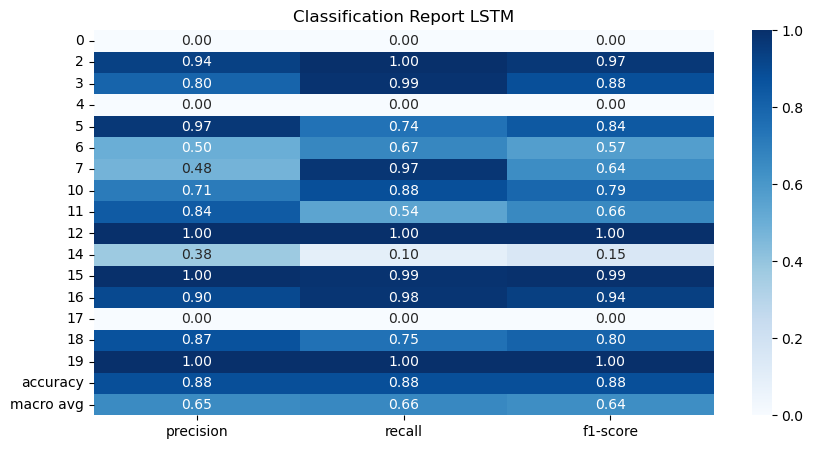

In [48]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

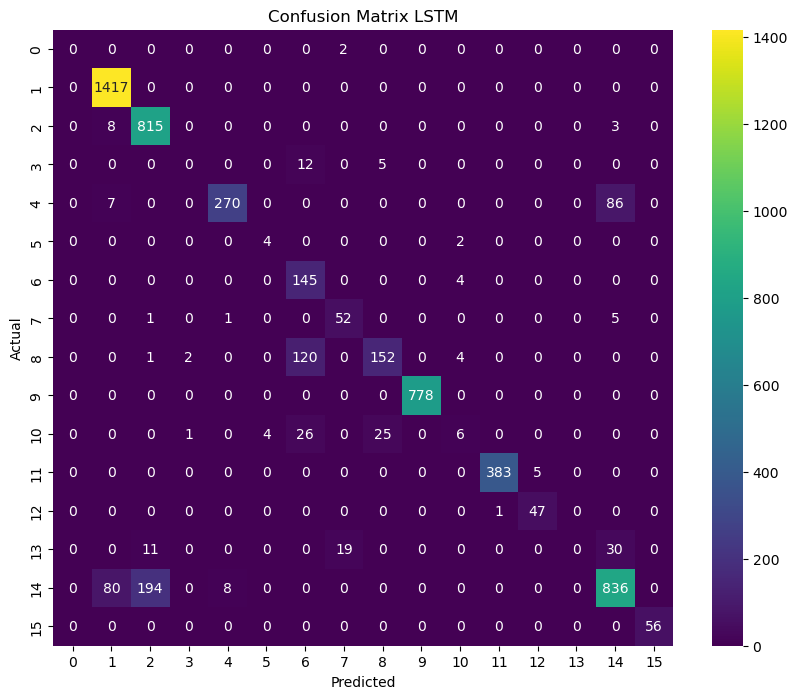

In [49]:
# Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

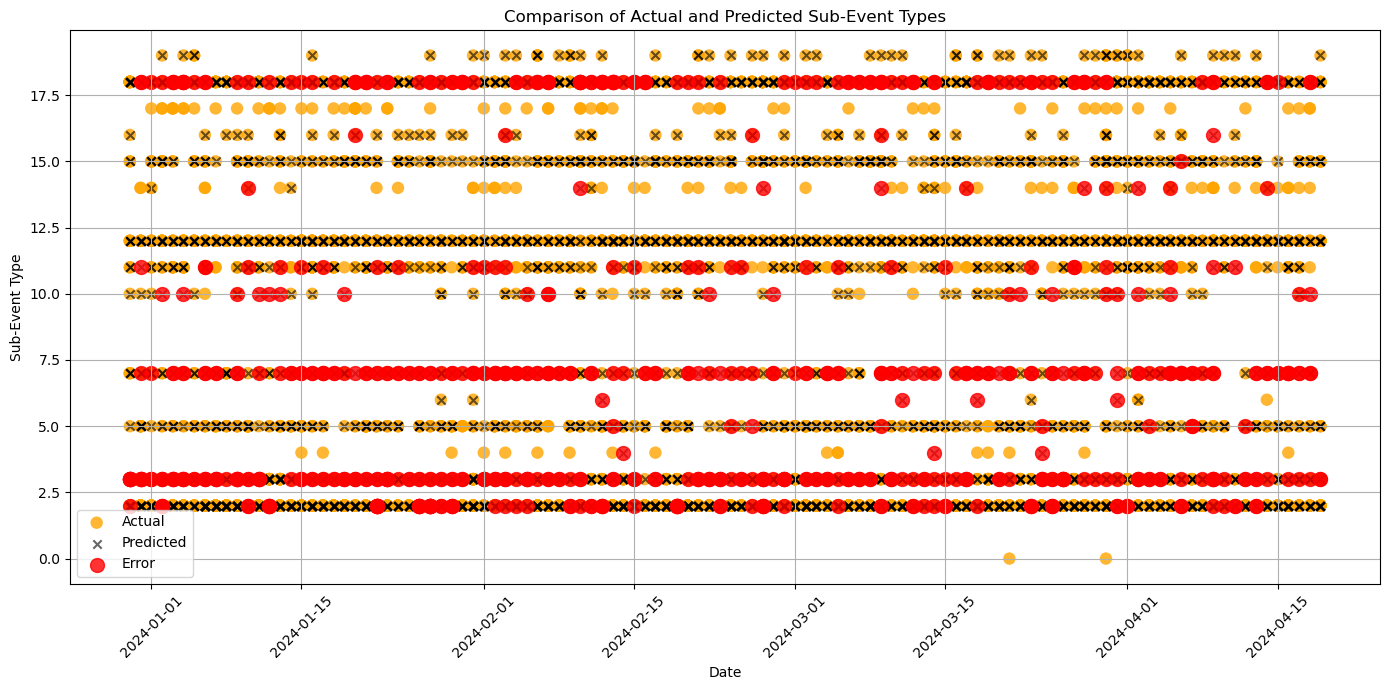

In [124]:
# Plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(results_LSTM_df.index, results_LSTM_df['actual_labels'], color='orange', label='Actual',s=80,  alpha=0.8, edgecolors='none')
ax.scatter(results_LSTM_df.index, results_LSTM_df['predicted_labels'], color='black', label='Predicted', marker='x', alpha=0.6)

# Errors
errors = results_LSTM_df[results_LSTM_df['actual_labels'] != results_LSTM_df['predicted_labels']]
ax.scatter(errors.index, errors['predicted_labels'], color='red', label='Error', s=100, alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
ax.set_title('Comparison of Actual and Predicted Sub-Event Types')
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

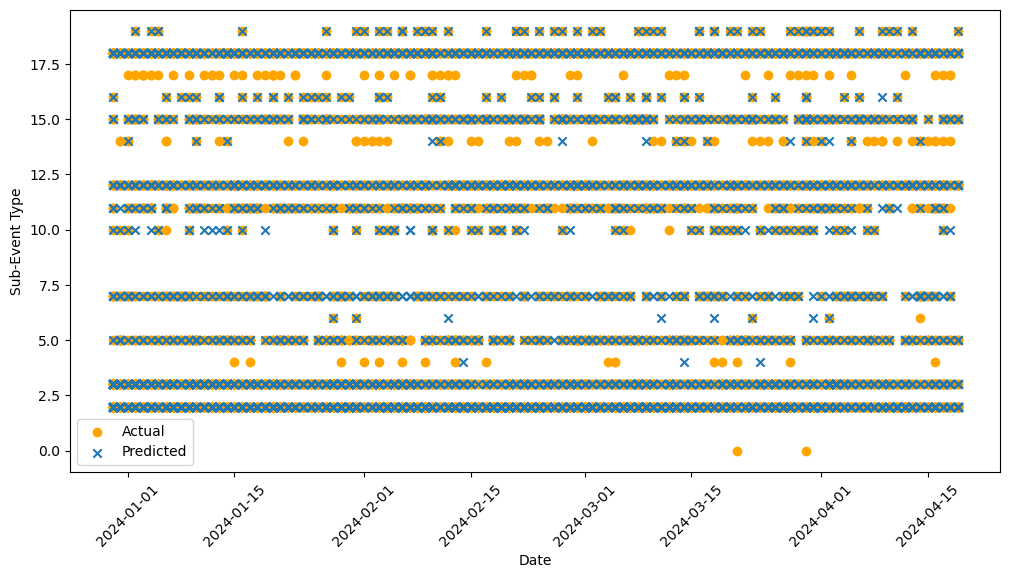

In [129]:
# event_dates for test set
event_dates_test = log_data_encoded.loc[test_idx, 'event_date'].reset_index(drop=True)

# match length of event_dates_test to actual_classes_LSTM and y_pred_classes_LSTM
event_dates_test = event_dates_test[-len(actual_classes_LSTM):]

all_labels = np.unique(y_train_labels)

# df with event_date, actual labels, and predicted labels
results_LSTM_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': [all_labels[i] for i in actual_classes_LSTM],
    'predicted_labels': [all_labels[i] for i in y_pred_classes_LSTM]
})

# converting datetime
results_LSTM_df['event_date'] = pd.to_datetime(results_LSTM_df['event_date'])

# Set event_date as the index
results_LSTM_df.set_index('event_date', inplace=True)

# Plot actual vs. predicted against time
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(results_LSTM_df.index, results_LSTM_df['actual_labels'], label='Actual', color = 'orange', marker='o')
ax.scatter(results_LSTM_df.index, results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
plt.xticks(rotation=45)
plt.show()

When circles and crosses are at the same level on the plot for a given date, it means the prediction was correct. The values that differ on the y-axis indicate a misprediction.

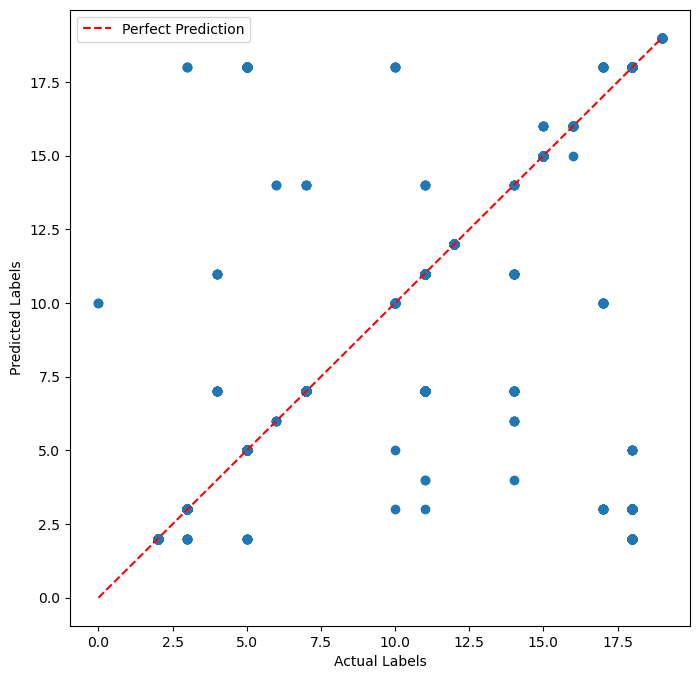

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_LSTM_df['actual_labels'], results_LSTM_df['predicted_labels'])
ax.plot([min(results_LSTM_df['actual_labels']), max(results_LSTM_df['actual_labels'])], [min(results_LSTM_df['actual_labels']), max(results_LSTM_df['actual_labels'])], 'r--', label='Perfect Prediction')
ax.set_xlabel('Actual Labels')
ax.set_ylabel('Predicted Labels')
ax.legend()
plt.show()

Future data exploration shows overfitting

In [52]:
# Create a new DataFrame with future dates for the next 6 months
#last_date = results_LSTM_df.index[-1]
#future_dates = pd.date_range(start=last_date, periods=6, freq='M')
#future_df = pd.DataFrame(index=future_dates, columns=['predicted_labels'])

# Predict labels for the future dates using the trained model
#future_X = future_X.reshape(future_X.shape[0], best_params[0], future_X.shape[2])
#future_labels = LSTM_embed_model_best.predict(future_X)
#future_labels_classes = np.argmax(future_labels, axis=1)
#future_df['predicted_labels'] = [all_labels[i] for i in future_labels_classes]

# Append the forecasted labels to the existing results_LSTM_df
#results_LSTM_df_forecast = pd.concat([results_LSTM_df, future_df])

# Plot the actual labels, predicted labels, and forecasted labels
#fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(results_LSTM_df.index, results_LSTM_df['actual_labels'], label='Actual')
#ax.plot(results_LSTM_df.index, results_LSTM_df['predicted_labels'], label='Predicted')
#ax.plot(future_df.index, future_df['predicted_labels'], label='Forecast', linestyle='--')
#ax.legend()
#ax.set_xlabel('Date')
#ax.set_ylabel('Sub-Event Type')
#plt.xticks(rotation=45)
#plt.show()

In [53]:
X_train_reshaped.shape

(22578, 24, 10)

In [54]:
# Testing 10% dropout and 50 neurons, 7 time steps - 0.843
# Testing 20% dropout and 50 neurons, 14 time steps - 0.829
# Testing 20% dropout and 100 neurons, 14 time steps - 0.827
# Testing 20% dropout and 50 neurons, 24 time steps - 0.814
# Testing 30% dropout and 100 neurons, 24 time steps - 0.879

In [55]:
#Grid Search for Hyperparamers - LSTM With Embedding
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        Input(shape=(n_steps, n_features)),
        LSTM(n_nodes, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [7, X_train_reshaped.shape[2], 75, 0.2, 20],  
    [7, X_train_reshaped.shape[2], 50, 0.3, 20],  
    [7, X_train_reshaped.shape[2], 100, 0.4, 20],  
    [24, X_train_reshaped.shape[2], 75, 0.2, 20],
    [24, X_train_reshaped.shape[2], 50, 0.3, 20],  
    [24, X_train_reshaped.shape[2], 100, 0.4, 20]
]

# run model with a specific config
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config

    #Reshaping data
    X_train_reshaped = create_sequences(X_train, n_steps)
    X_test_reshaped = create_sequences(X_test, n_steps)
    
    #matching labels to new data
    y_train_reshaped = y_train_labels[n_steps-1:]
    y_test_reshaped = y_test_labels[n_steps-1:]

    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

# grid search
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

Epoch 1/50


2024-05-05 15:37:18.697706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:37:18.895455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:37:18.991043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:37:19.115991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/318 [..............................] - ETA: 6s - loss: 2.9517 - accuracy: 0.1016  

2024-05-05 15:37:19.239691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.6911

2024-05-05 15:37:24.906024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:37:24.991980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:37:25.050012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 19ms/step - loss: 1.0995 - accuracy: 0.6911 - val_loss: 0.7370 - val_accuracy: 0.7580
Epoch 2/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2687 - accuracy: 0.9231 - val_loss: 0.5098 - val_accuracy: 0.8403
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2031 - accuracy: 0.9364 - val_loss: 0.4706 - val_accuracy: 0.8429
Epoch 4/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1758 - accuracy: 0.9460 - val_loss: 0.3820 - val_accuracy: 0.8739
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1612 - accuracy: 0.9490 - val_loss: 0.4044 - val_accuracy: 0.8531
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1470 - accuracy: 0.9531 - val_loss: 0.3732 - val_accuracy: 0.8792
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1381 - accuracy: 0.9560 - val_loss: 0.4222 - val_accuracy: 0.8624
Epoch 8/50

2024-05-05 15:38:57.240214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:38:57.418710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:38:57.494454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:38:57.614430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/318 [..............................] - ETA: 9s - loss: 2.9839 - accuracy: 0.0625  

2024-05-05 15:38:57.728136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.5723

2024-05-05 15:39:02.991357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:39:03.061041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:39:03.112173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 18ms/step - loss: 1.4585 - accuracy: 0.5723 - val_loss: 1.1150 - val_accuracy: 0.6407
Epoch 2/50
318/318 [==============================] - 5s 15ms/step - loss: 0.4159 - accuracy: 0.8954 - val_loss: 0.6036 - val_accuracy: 0.7956
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2699 - accuracy: 0.9255 - val_loss: 0.5182 - val_accuracy: 0.8221
Epoch 4/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2257 - accuracy: 0.9347 - val_loss: 0.4611 - val_accuracy: 0.8482
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1999 - accuracy: 0.9410 - val_loss: 0.4236 - val_accuracy: 0.8606
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1818 - accuracy: 0.9472 - val_loss: 0.4175 - val_accuracy: 0.8633
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1736 - accuracy: 0.9483 - val_loss: 0.3944 - val_accuracy: 0.8752
Epoch 8/50

2024-05-05 15:40:35.585830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:40:35.755215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:40:35.836413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:40:35.961666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/318 [..............................] - ETA: 8s - loss: 2.9906 - accuracy: 0.0521      

2024-05-05 15:40:36.085018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.6869

2024-05-05 15:40:41.484813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:40:41.557235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:40:41.613248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 18ms/step - loss: 1.0844 - accuracy: 0.6869 - val_loss: 0.7140 - val_accuracy: 0.7566
Epoch 2/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2752 - accuracy: 0.9185 - val_loss: 0.5089 - val_accuracy: 0.8186
Epoch 3/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2119 - accuracy: 0.9367 - val_loss: 0.4606 - val_accuracy: 0.8504
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1887 - accuracy: 0.9421 - val_loss: 0.4572 - val_accuracy: 0.8363
Epoch 5/50
318/318 [==============================] - 5s 15ms/step - loss: 0.1685 - accuracy: 0.9480 - val_loss: 0.3812 - val_accuracy: 0.8779
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1609 - accuracy: 0.9501 - val_loss: 0.3498 - val_accuracy: 0.8814
Epoch 7/50
318/318 [==============================] - 5s 15ms/step - loss: 0.1493 - accuracy: 0.9519 - val_loss: 0.3778 - val_accuracy: 0.8726
Epoch 8/50

2024-05-05 15:42:39.864688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:42:40.045730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:42:40.145726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:42:40.285963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/318 [..............................] - ETA: 9s - loss: 2.9429 - accuracy: 0.1250  

2024-05-05 15:42:40.425729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.6648

2024-05-05 15:42:46.435929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:42:46.517737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:42:46.576337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 20ms/step - loss: 1.1502 - accuracy: 0.6648 - val_loss: 0.8012 - val_accuracy: 0.7648
Epoch 2/50
318/318 [==============================] - 6s 18ms/step - loss: 0.2888 - accuracy: 0.9197 - val_loss: 0.5455 - val_accuracy: 0.8136
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2091 - accuracy: 0.9378 - val_loss: 0.5328 - val_accuracy: 0.8149
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1790 - accuracy: 0.9452 - val_loss: 0.4400 - val_accuracy: 0.8627
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1618 - accuracy: 0.9504 - val_loss: 0.4126 - val_accuracy: 0.8667
Epoch 6/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1499 - accuracy: 0.9542 - val_loss: 0.4090 - val_accuracy: 0.8733
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1400 - accuracy: 0.9578 - val_loss: 0.3849 - val_accuracy: 0.8778
Epoch 8/50

2024-05-05 15:44:53.134194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:44:53.313098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:44:53.409898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:44:53.549221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 7:23 - loss: 2.9992 - accuracy: 0.0156

2024-05-05 15:44:53.689096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.4493 - accuracy: 0.5656

2024-05-05 15:44:59.409435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:44:59.487660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:44:59.554657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 20ms/step - loss: 1.4493 - accuracy: 0.5656 - val_loss: 1.1445 - val_accuracy: 0.6329
Epoch 2/50
318/318 [==============================] - 5s 16ms/step - loss: 0.4720 - accuracy: 0.8814 - val_loss: 0.6666 - val_accuracy: 0.7852
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2842 - accuracy: 0.9235 - val_loss: 0.5810 - val_accuracy: 0.8069
Epoch 4/50
318/318 [==============================] - 6s 17ms/step - loss: 0.2313 - accuracy: 0.9331 - val_loss: 0.5436 - val_accuracy: 0.8286
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2106 - accuracy: 0.9375 - val_loss: 0.4553 - val_accuracy: 0.8534
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1923 - accuracy: 0.9429 - val_loss: 0.4290 - val_accuracy: 0.8623
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1800 - accuracy: 0.9467 - val_loss: 0.4327 - val_accuracy: 0.8663
Epoch 8/50

2024-05-05 15:47:30.168051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:47:30.363872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:47:30.473114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:47:30.623605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 11:18 - loss: 2.9902 - accuracy: 0.0156

2024-05-05 15:47:30.774140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.6564

2024-05-05 15:47:37.926334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:47:38.017875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:47:38.092232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 10s 24ms/step - loss: 1.1495 - accuracy: 0.6564 - val_loss: 0.7520 - val_accuracy: 0.7591
Epoch 2/50
318/318 [==============================] - 7s 23ms/step - loss: 0.2910 - accuracy: 0.9192 - val_loss: 0.5374 - val_accuracy: 0.8096
Epoch 3/50
318/318 [==============================] - 8s 26ms/step - loss: 0.2164 - accuracy: 0.9360 - val_loss: 0.5107 - val_accuracy: 0.8375
Epoch 4/50
318/318 [==============================] - 8s 24ms/step - loss: 0.1862 - accuracy: 0.9436 - val_loss: 0.4477 - val_accuracy: 0.8459
Epoch 5/50
318/318 [==============================] - 6s 18ms/step - loss: 0.1706 - accuracy: 0.9478 - val_loss: 0.4320 - val_accuracy: 0.8539
Epoch 6/50
318/318 [==============================] - 6s 18ms/step - loss: 0.1561 - accuracy: 0.9518 - val_loss: 0.3802 - val_accuracy: 0.8751
Epoch 7/50
318/318 [==============================] - 6s 18ms/step - loss: 0.1462 - accuracy: 0.9543 - val_loss: 0.3958 - val_accuracy: 0.8649
Epoch 8/5

In [56]:
# Retraining LSTM WITH EMBED
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        Input(shape=(n_steps, n_features)),
        LSTM(n_nodes, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# best parameters
best_params = best_config

n_steps = best_params[0]
X_train_reshaped = create_sequences(X_train, n_steps)
X_test_reshaped = create_sequences(X_test, n_steps)
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

LSTM_embed_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# train the model
history = LSTM_embed_model_best.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, 
                                    verbose=1, callbacks=[early_stopping])

Epoch 1/50


2024-05-05 15:50:03.138918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:50:03.329943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:50:03.427816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:50:03.587633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 8:01 - loss: 2.9854 - accuracy: 0.0625

2024-05-05 15:50:03.739735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1320 - accuracy: 0.6675

2024-05-05 15:50:09.797183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:50:09.879289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:50:09.950397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 21ms/step - loss: 1.1320 - accuracy: 0.6675 - val_loss: 0.6902 - val_accuracy: 0.7919
Epoch 2/50
318/318 [==============================] - 6s 17ms/step - loss: 0.2876 - accuracy: 0.9214 - val_loss: 0.5473 - val_accuracy: 0.8113
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2180 - accuracy: 0.9345 - val_loss: 0.4142 - val_accuracy: 0.8689
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1905 - accuracy: 0.9432 - val_loss: 0.4438 - val_accuracy: 0.8592
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1724 - accuracy: 0.9474 - val_loss: 0.4033 - val_accuracy: 0.8725
Epoch 6/50
318/318 [==============================] - 6s 18ms/step - loss: 0.1621 - accuracy: 0.9495 - val_loss: 0.3642 - val_accuracy: 0.8769
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1528 - accuracy: 0.9511 - val_loss: 0.3644 - val_accuracy: 0.8773
Epoch 8/50

In [ ]:
_, accuracy = LSTM_embed_model_best.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
print(f'Test Accuracy with Embed: {accuracy:.3f}')

# Predictions
y_pred_withembed = LSTM_embed_model_best.predict(X_test_reshaped)
y_pred_classes_withembed = np.argmax(y_pred_withembed, axis=1) # converting probabilities to class labels

# Actual classes
actual_classes_withembed = y_test_reshaped  

# Metrics
mae_LSTM_withembed = mean_absolute_error(actual_classes_withembed, y_pred_classes_withembed)
print(f'Mean Absolute Error LSTM With Embedding: {mae_LSTM_withembed:.2f}')

mse_LSTM_withembed = mean_squared_error(actual_classes_withembed, actual_classes_withembed)
print(f'MSE LSTM With Embedding: {mse_LSTM_withembed:.2f}')

rmse_LSTM_withembed = np.sqrt(mse_LSTM_withembed)
print(f'RMSE  LSTM With Embedding: {rmse_LSTM_withembed:.2f}')


2024-05-06 15:24:23.955538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-06 15:24:24.579580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [58]:
predicted_labels_withembed = [sub_event_type_labels[i] for i in y_pred_classes_withembed]
actual_labels_withembed = [sub_event_type_labels[i] for i in actual_classes_withembed]

for actual, predicted in zip(actual_labels_withembed[:10], predicted_labels_withembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Looting/property destruction
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Armed clash
Actual: Grenade, Predicted: Grenade
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [59]:
# showing errors
errors_withembed = np.where(y_pred_classes_withembed != actual_classes_withembed)[0]
print(f'Number of errors With Embed: {len(errors_withembed)} / {len(actual_classes_withembed)}')

for i in errors_withembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_withembed[i]}, Actual: {actual_classes_withembed[i]}')

Number of errors With Embed: 764 / 5628
Index: 2, Predicted: 3, Actual: 18
Index: 18, Predicted: 3, Actual: 18
Index: 19, Predicted: 3, Actual: 18
Index: 20, Predicted: 3, Actual: 18
Index: 35, Predicted: 2, Actual: 18
Index: 39, Predicted: 3, Actual: 18
Index: 40, Predicted: 3, Actual: 18
Index: 45, Predicted: 2, Actual: 18
Index: 57, Predicted: 3, Actual: 18
Index: 70, Predicted: 18, Actual: 5


              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000     2.00000
2              0.885072  1.000000  0.939032  1417.00000
3              0.787909  0.962470  0.866485   826.00000
4              0.000000  0.000000  0.000000    17.00000
5              0.946237  0.727273  0.822430   363.00000
6              0.375000  1.000000  0.545455     6.00000
7              0.663551  0.953020  0.782369   149.00000
8              0.000000  0.000000  0.000000     0.00000
10             0.870370  0.796610  0.831858    59.00000
11             0.833333  0.519713  0.640177   279.00000
12             1.000000  0.967866  0.983671   778.00000
14             0.221154  0.370968  0.277108    62.00000
15             1.000000  0.963918  0.981627   388.00000
16             0.854545  0.979167  0.912621    48.00000
17             0.750000  0.100000  0.176471    60.00000
18             0.849300  0.705725  0.770884  1118.00000
19             1.000000  1.000000  1.000000    5

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

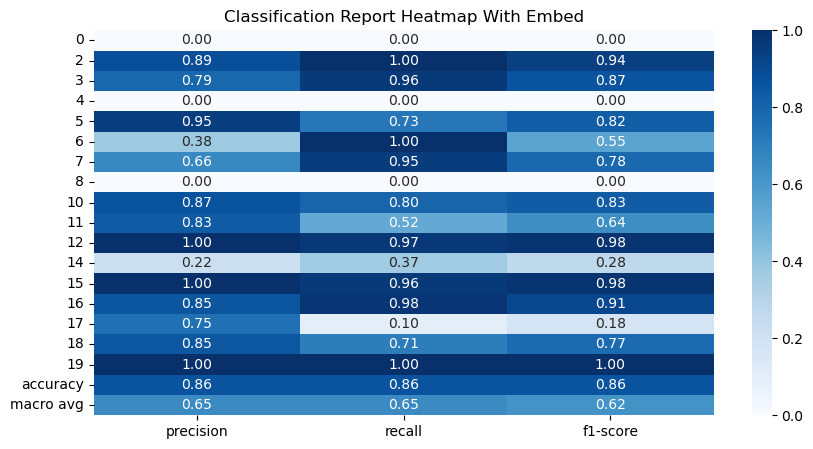

In [60]:
#  Classification report
report_withembed = classification_report(actual_classes_withembed, y_pred_classes_withembed, output_dict=True)
report_withembed_df = pd.DataFrame(report_withembed).transpose()
print(report_withembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_withembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap With Embed')
plt.show()

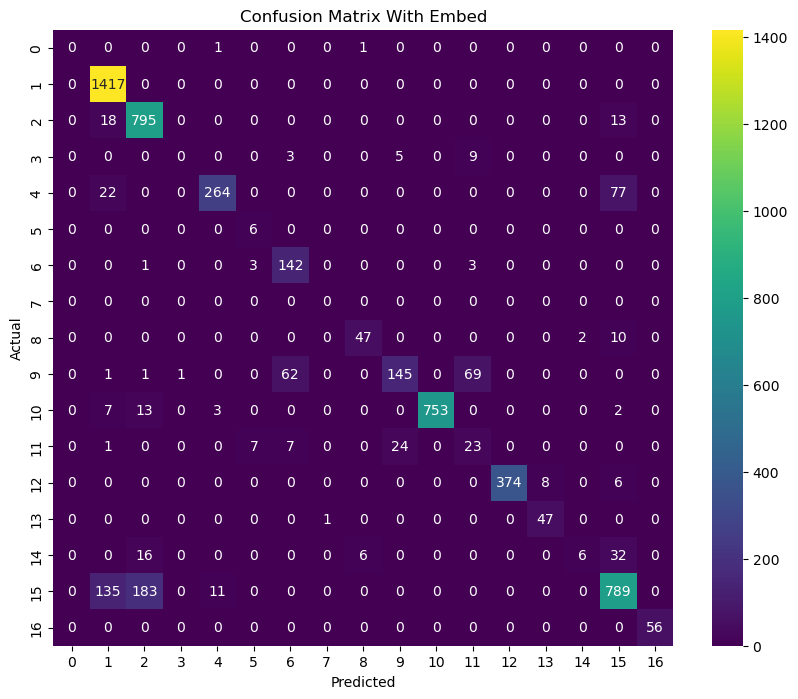

In [61]:
# Confusion Matrix
conf_matrix_withembed = confusion_matrix(actual_classes_withembed, y_pred_classes_withembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_withembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix With Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

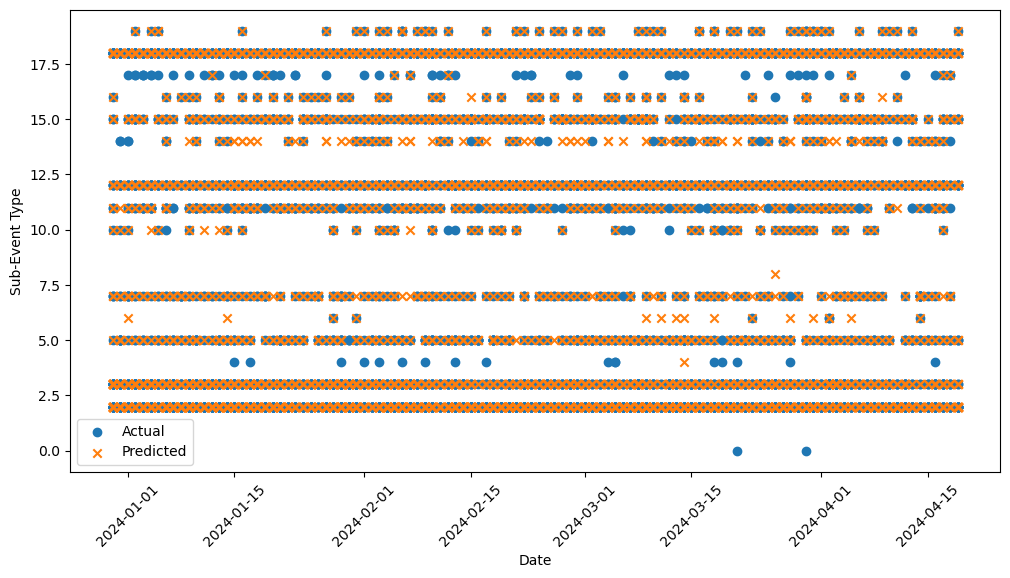

In [62]:
#Attempt to create actual vs. predicted against time

# match length of event_dates_test to actual and y classes
event_dates_test = event_dates_test[-len(actual_classes_withembed):]

all_labels = np.unique(y_train_labels)

# df with event_date, actual labels, and predicted labels
results_withembed_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': [all_labels[i] for i in actual_classes_withembed],
    'predicted_labels': [all_labels[i] for i in y_pred_classes_withembed]
})

# converting datetime
results_withembed_df['event_date'] = pd.to_datetime(results_withembed_df['event_date'])

results_withembed_df.set_index('event_date', inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(results_withembed_df.index, results_withembed_df['actual_labels'], label='Actual', marker='o')
ax.scatter(results_withembed_df.index, results_withembed_df['predicted_labels'], label='Predicted', marker='x')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
plt.xticks(rotation=45)
plt.show()

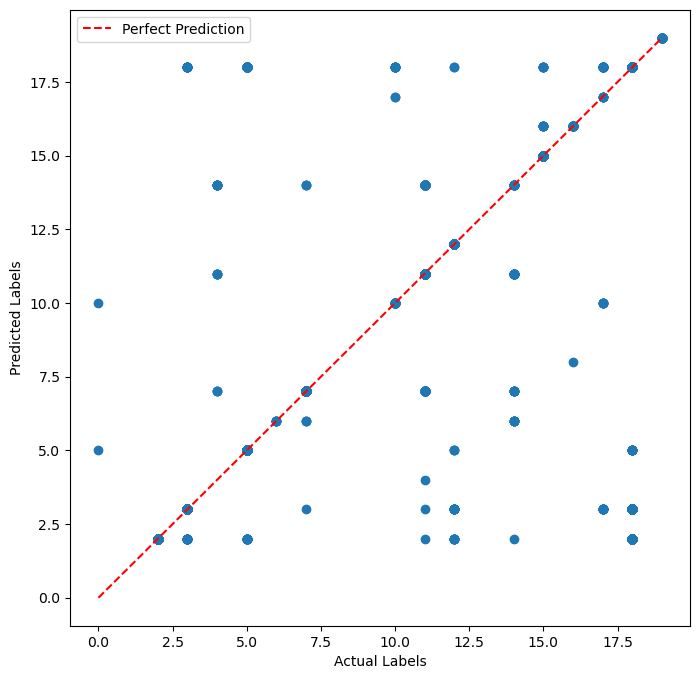

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_withembed_df['actual_labels'], results_withembed_df['predicted_labels'])
ax.plot([min(results_withembed_df['actual_labels']), max(results_withembed_df['actual_labels'])], 
        [min(results_withembed_df['actual_labels']), max(results_withembed_df['actual_labels'])], 'r--', label='Perfect Prediction')
ax.set_xlabel('Actual Labels')
ax.set_ylabel('Predicted Labels')
ax.legend()
plt.show()

In [64]:
#Control LSTM

In [65]:
log_data_encoded.columns

Index(['event_date', 'year', 'actor1', 'actor2', 'month', 'day',
       'days_since_start', 'rolling_avg_fatalities_7d',
       'cumulative_sub_events', 'cumulative_fatalities',
       ...
       'interaction_57', 'interaction_58', 'interaction_60', 'interaction_66',
       'interaction_68', 'interaction_70', 'interaction_77', 'interaction_78',
       'interaction_80', 'interaction_88'],
      dtype='object', length=146)

In [66]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(log_data_encoded.drop(columns=['event_date'] + sub_event_type_columns),
                                                    log_data_encoded[sub_event_type_columns],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

# Convert the target values to labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [67]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Labels for Y")
print(y_train_labels.shape)
print(y_test_labels.shape)
print(y_train_labels.dtype)
print(y_test_labels.dtype)
#print(train_idx.shape)
#print(test_idx.shape)
#print(X_train.dtypes)

(22601, 125)
(5651, 125)
(22601, 20)
(5651, 20)
Labels for Y
(22601,)
(5651,)
int64
int64


In [68]:
# Define the function to create the LSTM model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [69]:
# Prepare the data for LSTM
n_steps = 24
X_train_reshaped = create_sequences(X_train.to_numpy(), n_steps)
X_test_reshaped = create_sequences(X_test.to_numpy(), n_steps)
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

# configurations
n_classes = len(np.unique(y_train_reshaped))
configs = [
    [X_train_reshaped.shape[2], 50, 0.1, n_classes],  # Testing 10% dropout and 50 neurons
    [X_train_reshaped.shape[2], 50, 0.2, n_classes],  # Testing 20% dropout and 50 neurons
    [X_train_reshaped.shape[2], 100, 0.2, n_classes], # Testing 20% dropout and 100 neurons
    [X_train_reshaped.shape[2], 100, 0.3, n_classes], # Testing 30% dropout and 100 neurons
]

# running model with a specific config
def run_model(config):
    n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

# grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')


Epoch 1/50


2024-05-05 15:52:40.924625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:52:41.118028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:52:41.224663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:52:41.389389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 11:58 - loss: 2.9254 - accuracy: 0.0469

2024-05-05 15:52:41.551564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.6261 - accuracy: 0.4525

2024-05-05 15:52:47.419016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:52:47.497578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:52:47.567596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 20ms/step - loss: 1.6261 - accuracy: 0.4525 - val_loss: 1.3848 - val_accuracy: 0.4398
Epoch 2/50
318/318 [==============================] - 5s 17ms/step - loss: 0.8667 - accuracy: 0.7199 - val_loss: 1.4363 - val_accuracy: 0.6249
Epoch 3/50
318/318 [==============================] - 6s 19ms/step - loss: 0.5898 - accuracy: 0.8170 - val_loss: 1.3371 - val_accuracy: 0.6386
Epoch 4/50
318/318 [==============================] - 6s 20ms/step - loss: 0.4241 - accuracy: 0.8623 - val_loss: 1.3476 - val_accuracy: 0.6851
Epoch 5/50
318/318 [==============================] - 9s 27ms/step - loss: 0.3353 - accuracy: 0.8912 - val_loss: 0.6334 - val_accuracy: 0.7436
Epoch 6/50
318/318 [==============================] - 7s 23ms/step - loss: 0.2712 - accuracy: 0.9159 - val_loss: 0.5550 - val_accuracy: 0.7843
Epoch 7/50
318/318 [==============================] - 8s 26ms/step - loss: 0.2186 - accuracy: 0.9345 - val_loss: 0.6145 - val_accuracy: 0.7679
Epoch 8/50

2024-05-05 15:54:16.147599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:54:16.341686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:54:16.452898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:54:16.613093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 9:19 - loss: 3.0379 - accuracy: 0.0625

2024-05-05 15:54:16.766400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.7306 - accuracy: 0.4022

2024-05-05 15:54:22.732924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:54:22.818639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:54:22.918304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 21ms/step - loss: 1.7306 - accuracy: 0.4022 - val_loss: 1.3692 - val_accuracy: 0.4615
Epoch 2/50
318/318 [==============================] - 6s 18ms/step - loss: 1.0744 - accuracy: 0.6285 - val_loss: 1.1773 - val_accuracy: 0.5633
Epoch 3/50
318/318 [==============================] - 6s 18ms/step - loss: 0.7426 - accuracy: 0.7556 - val_loss: 1.2606 - val_accuracy: 0.5815
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.5926 - accuracy: 0.8095 - val_loss: 1.0423 - val_accuracy: 0.6129
Epoch 5/50
318/318 [==============================] - 6s 20ms/step - loss: 0.4868 - accuracy: 0.8451 - val_loss: 1.3038 - val_accuracy: 0.6138
Epoch 6/50
318/318 [==============================] - 5s 17ms/step - loss: 0.4299 - accuracy: 0.8599 - val_loss: 1.3083 - val_accuracy: 0.6262
Epoch 7/50
318/318 [==============================] - 6s 17ms/step - loss: 0.3636 - accuracy: 0.8838 - val_loss: 1.4858 - val_accuracy: 0.6528
Epoch 8/50

2024-05-05 15:55:11.427741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:55:11.609505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:55:11.743916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:55:11.948285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 8:49 - loss: 3.0624 - accuracy: 0.0000e+00

2024-05-05 15:55:12.156618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.5846

2024-05-05 15:55:18.843759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:55:18.923524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:55:19.035998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 23ms/step - loss: 1.2730 - accuracy: 0.5846 - val_loss: 0.8979 - val_accuracy: 0.6935
Epoch 2/50
318/318 [==============================] - 6s 17ms/step - loss: 0.6035 - accuracy: 0.8027 - val_loss: 0.7583 - val_accuracy: 0.7214
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.4212 - accuracy: 0.8687 - val_loss: 1.0315 - val_accuracy: 0.6701
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.3114 - accuracy: 0.9011 - val_loss: 0.9961 - val_accuracy: 0.7099
Epoch 5/50
318/318 [==============================] - 6s 18ms/step - loss: 0.2528 - accuracy: 0.9168 - val_loss: 0.8358 - val_accuracy: 0.7219
Epoch 6/50
318/318 [==============================] - 6s 20ms/step - loss: 0.2042 - accuracy: 0.9337 - val_loss: 0.6806 - val_accuracy: 0.7675
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1969 - accuracy: 0.9331 - val_loss: 0.4136 - val_accuracy: 0.8450
Epoch 8/50

2024-05-05 15:56:44.278652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:44.467598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:44.629819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:44.862484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:45.148154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.5608

2024-05-05 15:56:52.417771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:52.566931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:56:52.883282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 10s 26ms/step - loss: 1.3544 - accuracy: 0.5608 - val_loss: 0.9405 - val_accuracy: 0.6656
Epoch 2/50
318/318 [==============================] - 6s 19ms/step - loss: 0.6977 - accuracy: 0.7630 - val_loss: 0.7947 - val_accuracy: 0.6572
Epoch 3/50
318/318 [==============================] - 6s 19ms/step - loss: 0.4785 - accuracy: 0.8419 - val_loss: 0.8195 - val_accuracy: 0.6944
Epoch 4/50
318/318 [==============================] - 7s 23ms/step - loss: 0.3840 - accuracy: 0.8718 - val_loss: 0.6292 - val_accuracy: 0.7294
Epoch 5/50
318/318 [==============================] - 7s 22ms/step - loss: 0.3061 - accuracy: 0.8969 - val_loss: 0.7869 - val_accuracy: 0.7099
Epoch 6/50
318/318 [==============================] - 6s 19ms/step - loss: 0.2469 - accuracy: 0.9188 - val_loss: 0.6614 - val_accuracy: 0.7427
Epoch 7/50
318/318 [==============================] - 7s 22ms/step - loss: 0.2264 - accuracy: 0.9242 - val_loss: 0.8011 - val_accuracy: 0.7152
Epoch 8/5

In [70]:
# Retraining with best parameters
n_features, n_nodes, dropout_rate, _ = best_config
best_model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
loss_noembed, accuracy_noembed = best_model.evaluate(X_test_reshaped, y_test_reshaped)
print(f'Test Accuracy Without Embed: {accuracy_noembed:.2f}')

Epoch 1/50


2024-05-05 15:58:31.049028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:31.246669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:31.392869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:31.641911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:31.886991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.7332 - accuracy: 0.4286

2024-05-05 15:58:38.820396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:38.900642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:58:39.008005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 24ms/step - loss: 1.7332 - accuracy: 0.4286 - val_loss: 1.3434 - val_accuracy: 0.5089
Epoch 2/50
318/318 [==============================] - 8s 26ms/step - loss: 1.0279 - accuracy: 0.6846 - val_loss: 1.1586 - val_accuracy: 0.5248
Epoch 3/50
318/318 [==============================] - 7s 21ms/step - loss: 0.7300 - accuracy: 0.7729 - val_loss: 0.9764 - val_accuracy: 0.6165
Epoch 4/50
318/318 [==============================] - 8s 24ms/step - loss: 0.5806 - accuracy: 0.8150 - val_loss: 0.8119 - val_accuracy: 0.6678
Epoch 5/50
318/318 [==============================] - 8s 25ms/step - loss: 0.4717 - accuracy: 0.8519 - val_loss: 0.8540 - val_accuracy: 0.7002
Epoch 6/50
318/318 [==============================] - 9s 28ms/step - loss: 0.3876 - accuracy: 0.8817 - val_loss: 0.6613 - val_accuracy: 0.8091
Epoch 7/50
318/318 [==============================] - 7s 21ms/step - loss: 0.3211 - accuracy: 0.9044 - val_loss: 0.9249 - val_accuracy: 0.7591
Epoch 8/50

In [71]:
# Predictions
y_pred_noembed = best_model.predict(X_test_reshaped)
y_pred_classes_noembed = np.argmax(y_pred_noembed, axis=1)

# Actual class
actual_classes_noembed = y_test_reshaped

# Metrics
mae_LSTM_noembed = mean_absolute_error(actual_classes_noembed, y_pred_classes_noembed)
print(f'Mean Absolute Error LSTM: {mae_LSTM_noembed:.2f}')

mse_LSTM_noembed = mean_squared_error(actual_classes_noembed, y_pred_classes_noembed)
print(f'Mean Squared Error LSTM: {mse_LSTM_noembed:.2f}')

rmse_LSTM_noembed = np.sqrt(mse_LSTM_noembed)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM_noembed:.2f}')

2024-05-05 15:59:56.198520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-05 15:59:56.294598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/176 [..............................] - ETA: 2:20

2024-05-05 15:59:56.559586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 2s 7ms/step
Mean Absolute Error LSTM: 3.46
Mean Squared Error LSTM: 47.09
Root Mean Squared Error LSTM: 6.86


In [72]:
#Actual vs Pred
predicted_labels_noembed = [sub_event_type_labels[i] for i in y_pred_classes_noembed]
actual_labels_noembed = [sub_event_type_labels[i] for i in actual_classes_noembed]

for actual, predicted in zip(actual_labels_noembed[:10], predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Looting/property destruction
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Armed clash
Actual: Grenade, Predicted: Disrupted weapons use
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [73]:
# Showing errors
errors_noembed = np.where(y_pred_classes_noembed != actual_classes_noembed)[0]
print(f'Number of errors Without Embed: {len(errors_noembed)} / {len(actual_classes_noembed)}')
for i in errors_noembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_noembed[i]}, Actual: {actual_classes_noembed[i]}')


Number of errors Without Embed: 1965 / 5628
Index: 2, Predicted: 3, Actual: 18
Index: 3, Predicted: 7, Actual: 10
Index: 11, Predicted: 3, Actual: 18
Index: 13, Predicted: 3, Actual: 18
Index: 15, Predicted: 7, Actual: 16
Index: 17, Predicted: 3, Actual: 18
Index: 18, Predicted: 3, Actual: 18
Index: 19, Predicted: 3, Actual: 18
Index: 20, Predicted: 3, Actual: 18
Index: 30, Predicted: 3, Actual: 18


              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000     2.000000
2              0.988145  1.000000  0.994037  1417.000000
3              0.348039  0.945521  0.508795   826.000000
4              0.000000  0.000000  0.000000    17.000000
5              1.000000  0.046832  0.089474   363.000000
6              0.000000  0.000000  0.000000     6.000000
7              0.491870  0.812081  0.612658   149.000000
10             0.000000  0.000000  0.000000    59.000000
11             0.633540  0.365591  0.463636   279.000000
12             0.964064  1.000000  0.981703   778.000000
14             0.016667  0.048387  0.024793    62.000000
15             1.000000  1.000000  1.000000   388.000000
16             0.000000  0.000000  0.000000    48.000000
17             0.000000  0.000000  0.000000    60.000000
18             0.000000  0.000000  0.000000  1118.000000
19             1.000000  1.000000  1.000000    56.000000
accuracy       0.650853  0.6508

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

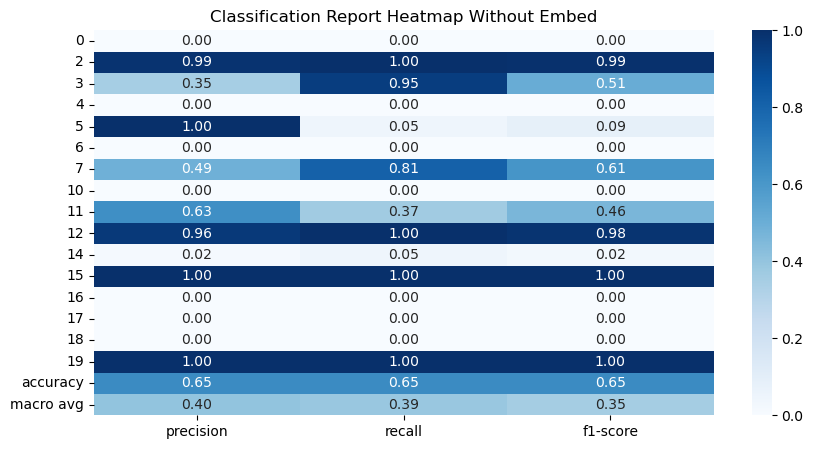

In [74]:
# Classification report
report_noembed = classification_report(actual_classes_noembed, y_pred_classes_noembed, output_dict=True)
report_noembed_df = pd.DataFrame(report_noembed).transpose()
print(report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap Without Embed')
plt.show()

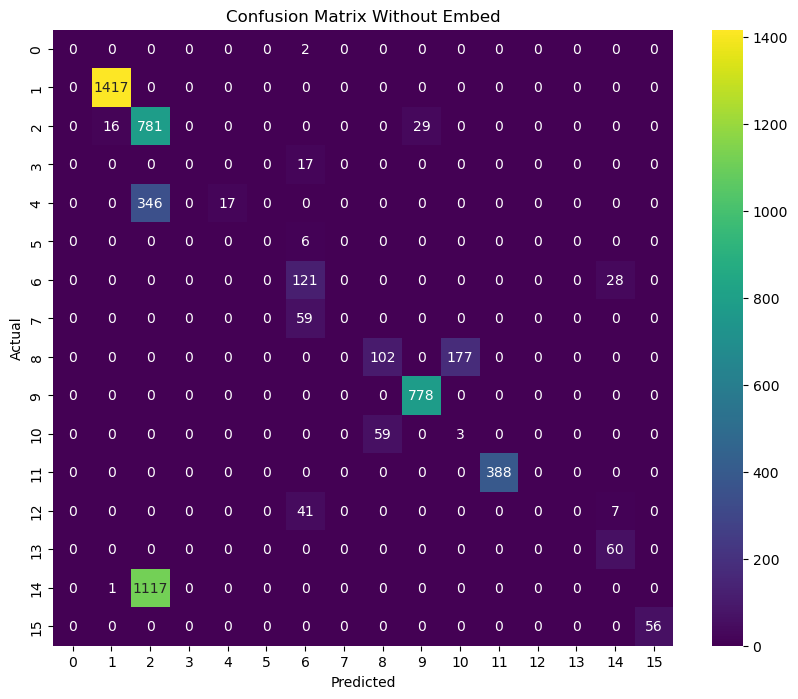

In [75]:
# Confusion Matrix
conf_matrix_noembed = confusion_matrix(actual_classes_noembed, y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix Without Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

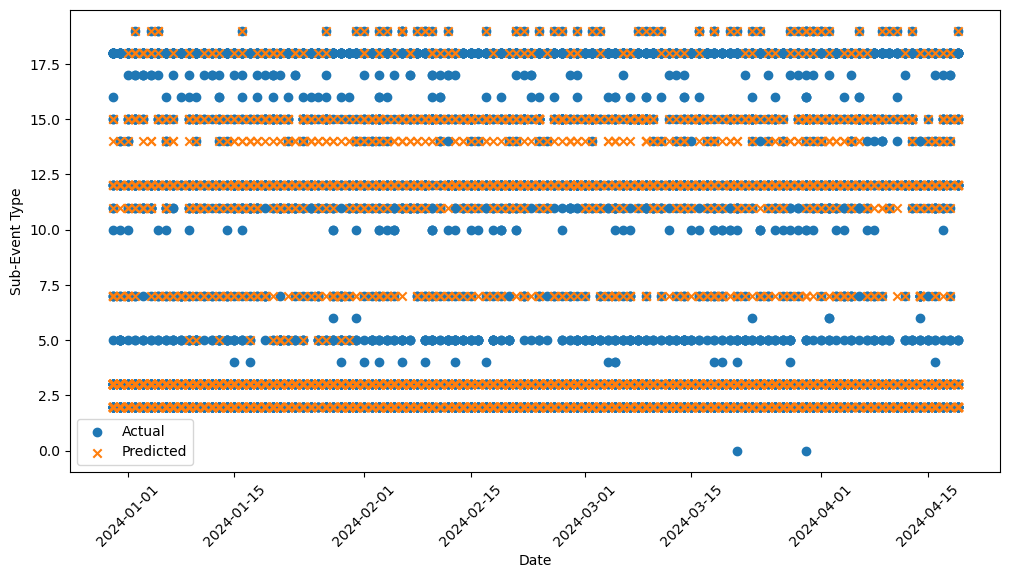

In [76]:
#Attempt to create actual vs. predicted against time

# match length of event_dates_test to actual and y classes
event_dates_test = event_dates_test[-len(actual_classes_noembed):]

all_labels = np.unique(y_train_labels)

# df with event_date, actual labels, and predicted labels
results_noembed_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': [all_labels[i] for i in actual_classes_noembed],
    'predicted_labels': [all_labels[i] for i in y_pred_classes_noembed]
})

# converting datetime
results_noembed_df['event_date'] = pd.to_datetime(results_noembed_df['event_date'])

results_noembed_df.set_index('event_date', inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(results_noembed_df.index, results_noembed_df['actual_labels'], label='Actual', marker='o')
ax.scatter(results_noembed_df.index, results_noembed_df['predicted_labels'], label='Predicted', marker='x')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
plt.xticks(rotation=45)
plt.show()

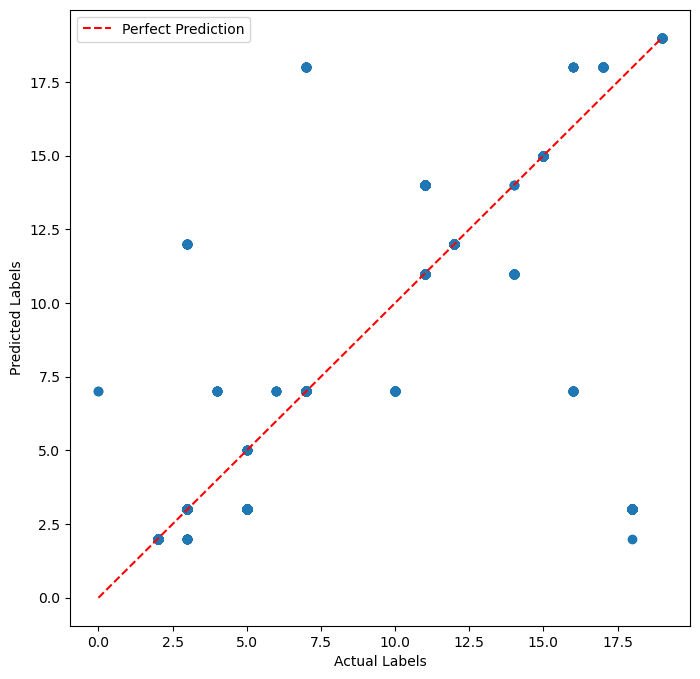

In [77]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_noembed_df['actual_labels'], results_noembed_df['predicted_labels'])
ax.plot([min(results_noembed_df['actual_labels']), max(results_noembed_df['actual_labels'])], 
        [min(results_noembed_df['actual_labels']), max(results_noembed_df['actual_labels'])], 'r--', label='Perfect Prediction')
ax.set_xlabel('Actual Labels')
ax.set_ylabel('Predicted Labels')
ax.legend()
plt.show()